In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [5]:
# Load the dataset

df = pd.read_csv("data/raw/healthcare-dataset-stroke-data.csv")

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (5110, 12)

First 5 rows:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset Info:


In [6]:
## 2. Data Cleaning and Preprocessing

# Check unique values in categorical columns
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    print(f"\n{col}: {df[col].unique()}")

# Handle missing values in BMI
print(f"\nBMI missing values: {df['bmi'].isnull().sum()}")

# Fill missing BMI values with median (grouped by gender and age group)
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 50, 65, 100], labels=['<18', '18-30', '30-50', '50-65', '65+'])
df['bmi'] = df.groupby(['gender', 'age_group'])['bmi'].transform(lambda x: x.fillna(x.median()))

# If there are still missing values, fill with overall median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Remove 'Other' gender category (only 1 instance) and 'Unknown' smoking status for cleaner analysis
df = df[df['gender'] != 'Other']
print(f"Dataset shape after removing 'Other' gender: {df.shape}")

# Check stroke distribution
print(f"\nStroke Distribution:")
print(df['stroke'].value_counts())
print(f"Stroke percentage: {df['stroke'].mean()*100:.2f}%")


gender: ['Male' 'Female' 'Other']

ever_married: ['Yes' 'No']

work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Residence_type: ['Urban' 'Rural']

smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']

BMI missing values: 201
Dataset shape after removing 'Other' gender: (5109, 13)

Stroke Distribution:
stroke
0    4860
1     249
Name: count, dtype: int64
Stroke percentage: 4.87%


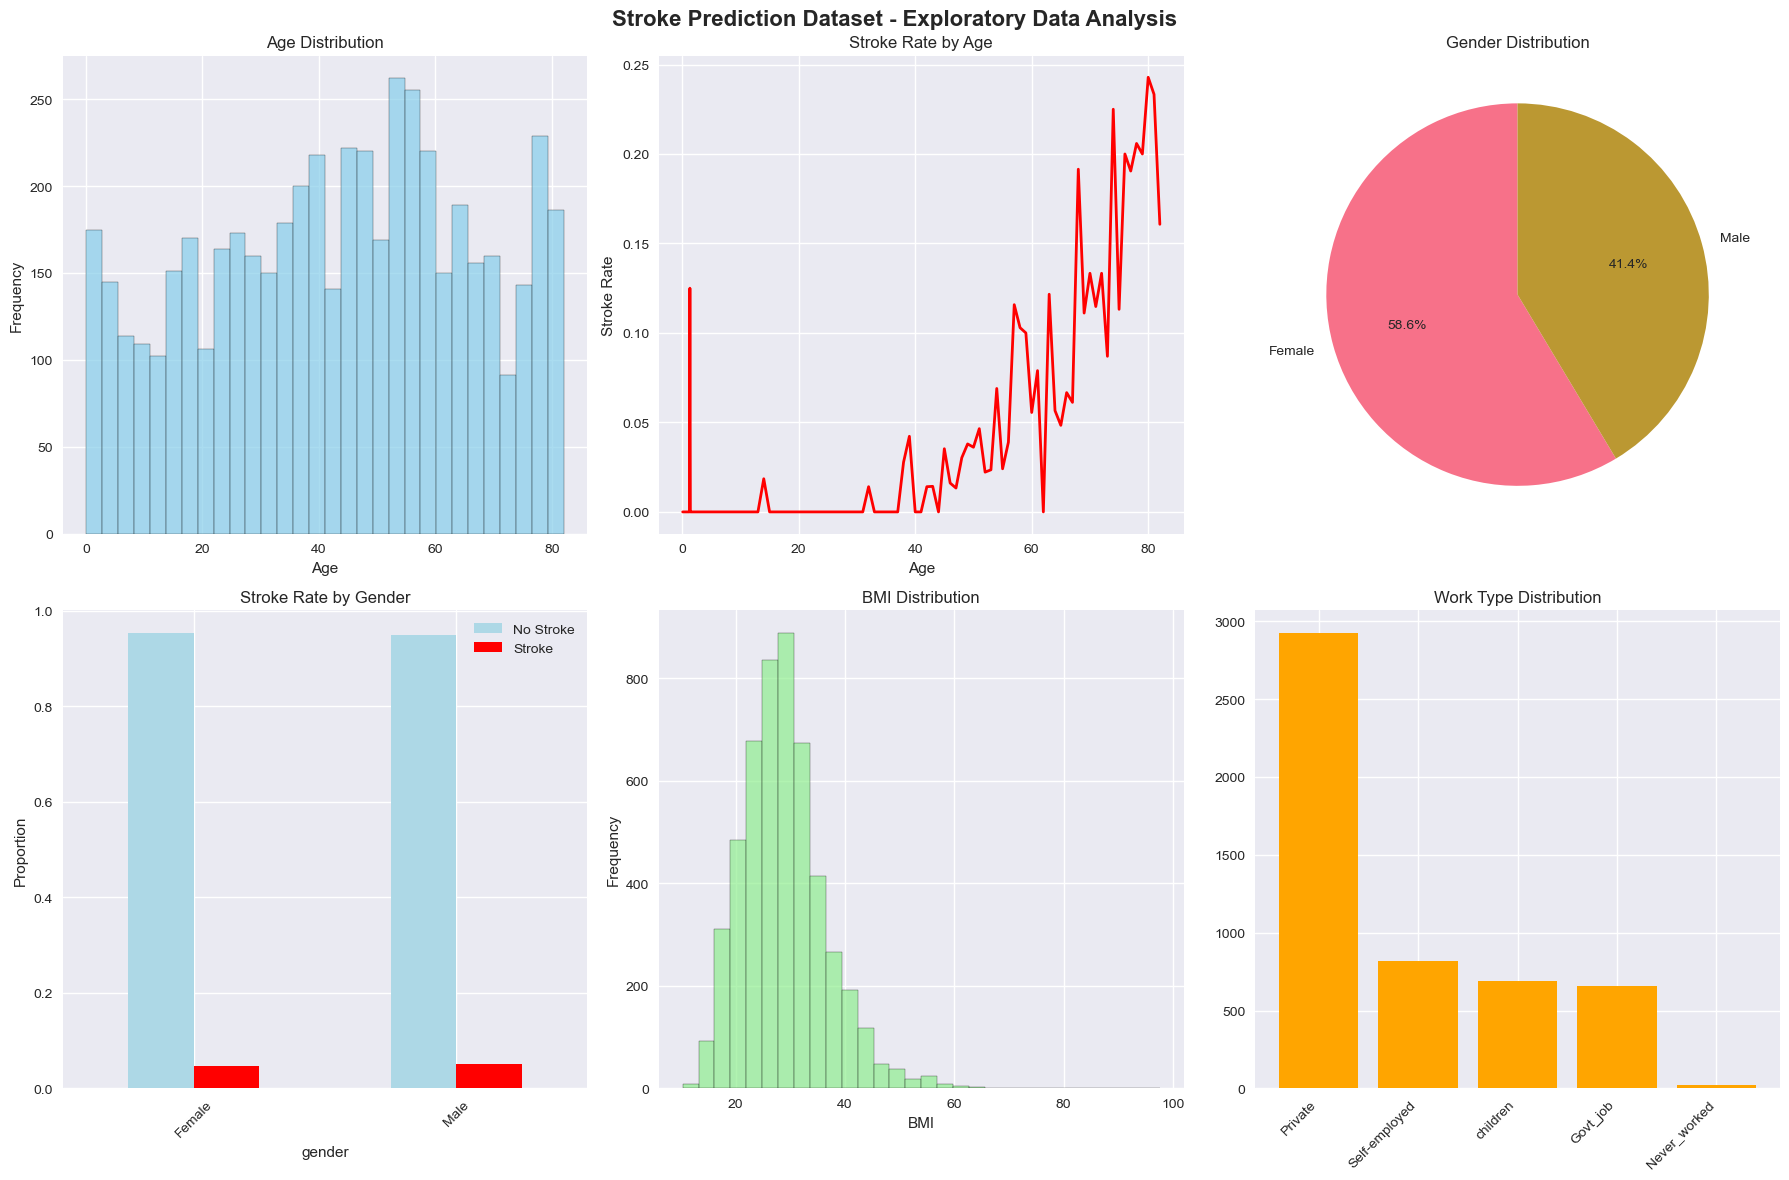

In [7]:
## 3. Exploratory Data Analysis

# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Stroke Prediction Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Age distribution
axes[0, 0].hist(df['age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# Stroke by age
stroke_by_age = df.groupby('age')['stroke'].mean().reset_index()
axes[0, 1].plot(stroke_by_age['age'], stroke_by_age['stroke'], color='red', linewidth=2)
axes[0, 1].set_title('Stroke Rate by Age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Stroke Rate')

# Gender distribution
gender_counts = df['gender'].value_counts()
axes[0, 2].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Gender Distribution')

# Stroke by gender
stroke_gender = pd.crosstab(df['gender'], df['stroke'], normalize='index')
stroke_gender.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'red'])
axes[1, 0].set_title('Stroke Rate by Gender')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].legend(['No Stroke', 'Stroke'])
axes[1, 0].tick_params(axis='x', rotation=45)

# BMI distribution
axes[1, 1].hist(df['bmi'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('BMI Distribution')
axes[1, 1].set_xlabel('BMI')
axes[1, 1].set_ylabel('Frequency')

# Work type distribution
work_counts = df['work_type'].value_counts()
axes[1, 2].bar(range(len(work_counts)), work_counts.values, color='orange')
axes[1, 2].set_title('Work Type Distribution')
axes[1, 2].set_xticks(range(len(work_counts)))
axes[1, 2].set_xticklabels(work_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


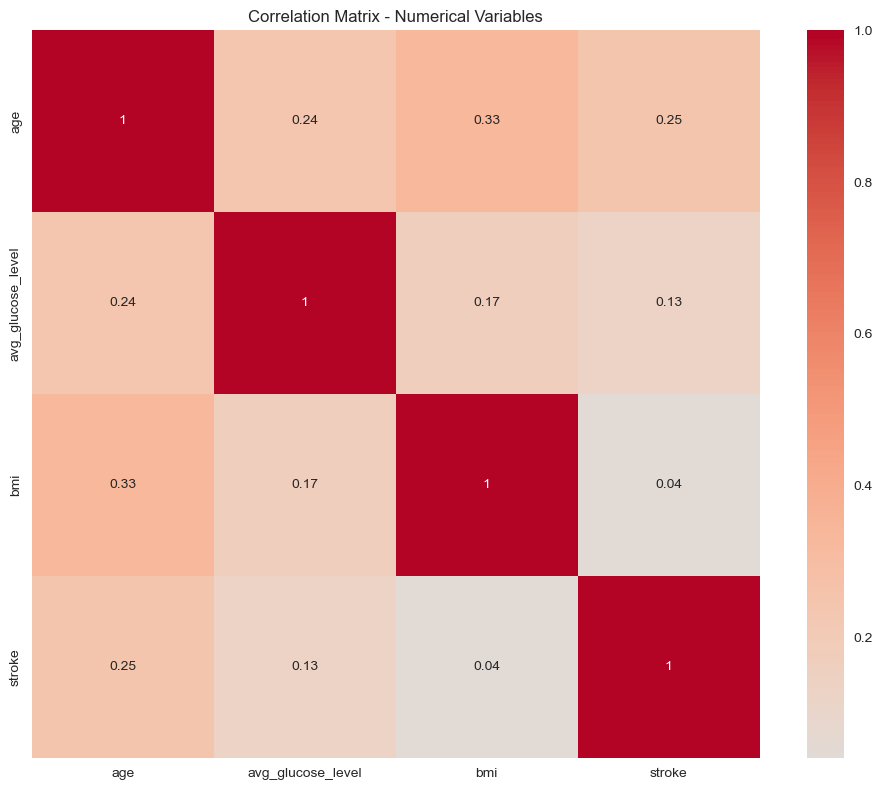

In [8]:
## 4. Correlation Analysis

# Create correlation heatmap for numerical variables
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix - Numerical Variables')
plt.tight_layout()
plt.show()

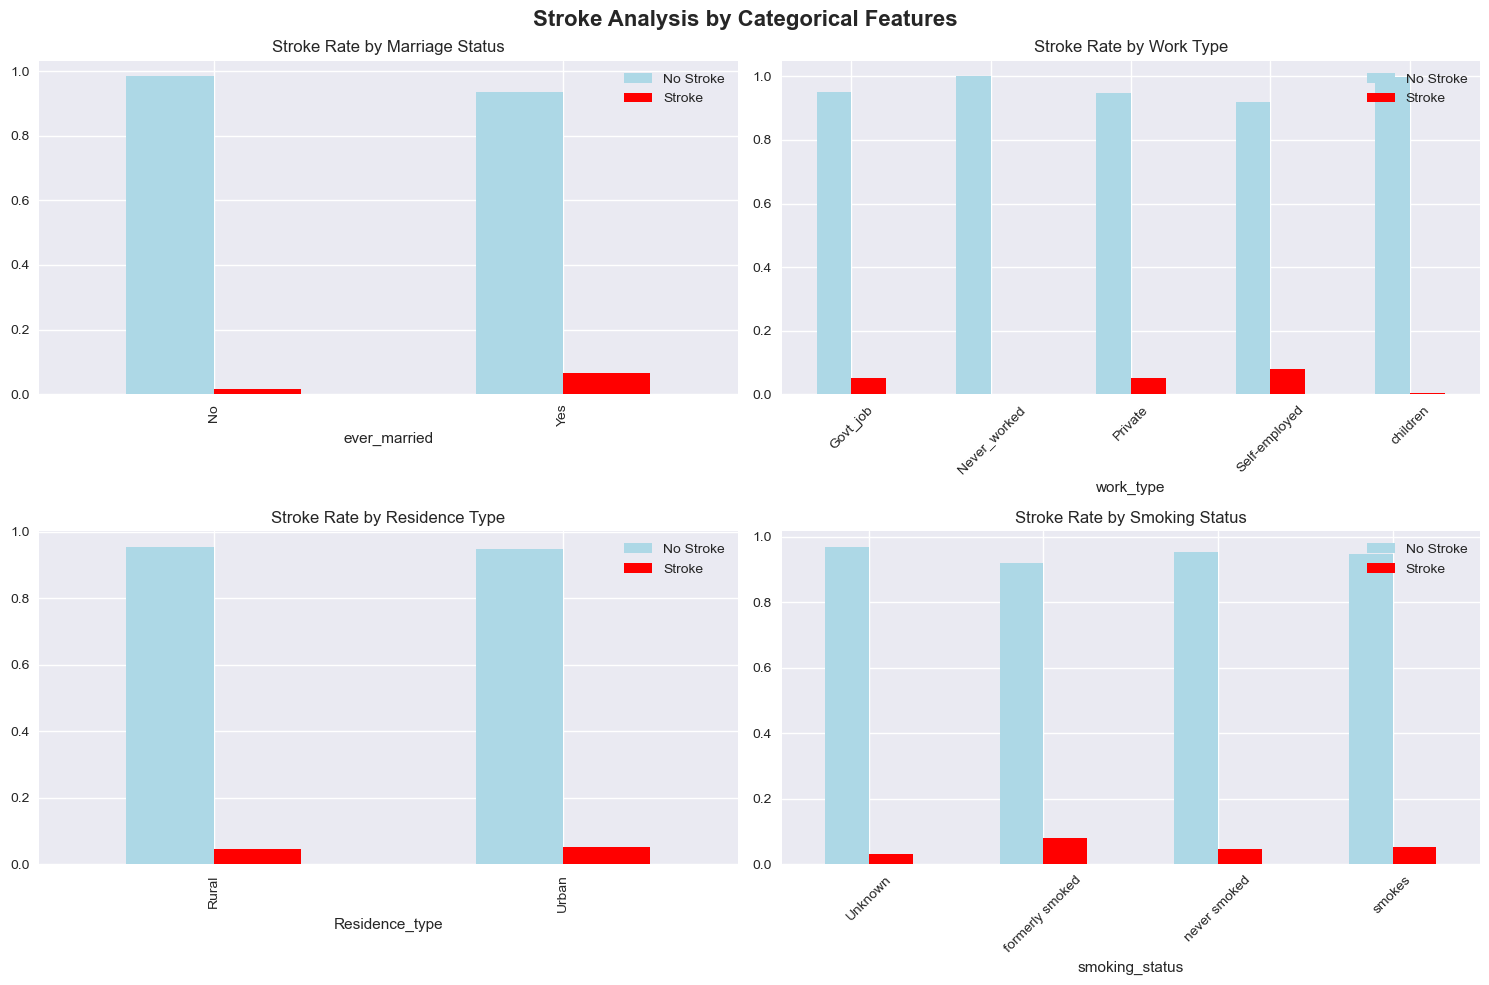

In [9]:
# 5. Feature Analysis

# Analyze categorical features vs stroke
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stroke Analysis by Categorical Features', fontsize=16, fontweight='bold')

# Marriage status
marriage_stroke = pd.crosstab(df['ever_married'], df['stroke'], normalize='index')
marriage_stroke.plot(kind='bar', ax=axes[0, 0], color=['lightblue', 'red'])
axes[0, 0].set_title('Stroke Rate by Marriage Status')
axes[0, 0].legend(['No Stroke', 'Stroke'])

# Work type
work_stroke = pd.crosstab(df['work_type'], df['stroke'], normalize='index')
work_stroke.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'red'])
axes[0, 1].set_title('Stroke Rate by Work Type')
axes[0, 1].legend(['No Stroke', 'Stroke'])
axes[0, 1].tick_params(axis='x', rotation=45)

# Residence type
residence_stroke = pd.crosstab(df['Residence_type'], df['stroke'], normalize='index')
residence_stroke.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'red'])
axes[1, 0].set_title('Stroke Rate by Residence Type')
axes[1, 0].legend(['No Stroke', 'Stroke'])

# Smoking status
smoking_stroke = pd.crosstab(df['smoking_status'], df['stroke'], normalize='index')
smoking_stroke.plot(kind='bar', ax=axes[1, 1], color=['lightblue', 'red'])
axes[1, 1].set_title('Stroke Rate by Smoking Status')
axes[1, 1].legend(['No Stroke', 'Stroke'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


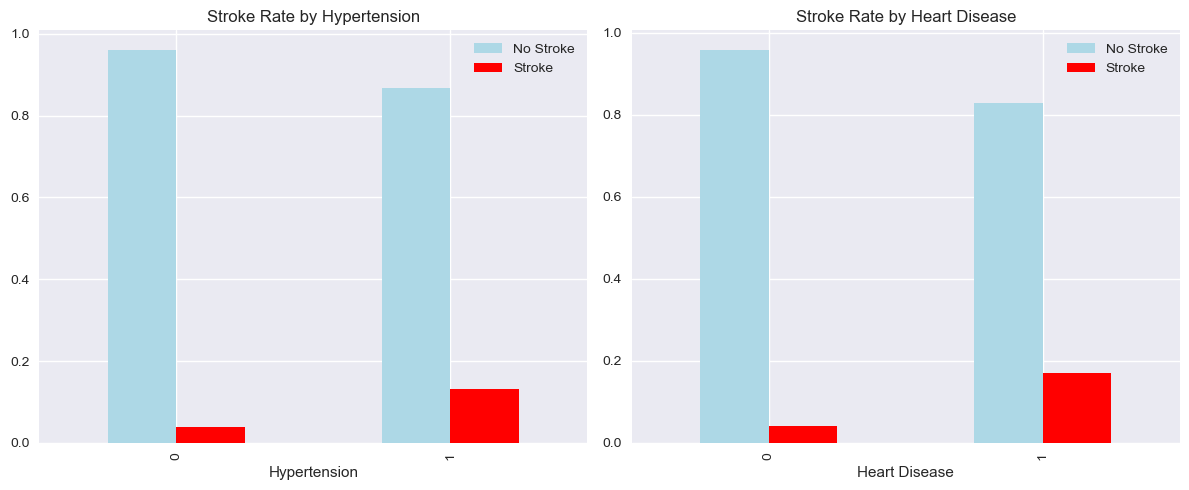

In [10]:
## 6. Health Conditions Analysis

# Analyze health conditions
health_conditions = ['hypertension', 'heart_disease']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, condition in enumerate(health_conditions):
    condition_stroke = pd.crosstab(df[condition], df['stroke'], normalize='index')
    condition_stroke.plot(kind='bar', ax=axes[i], color=['lightblue', 'red'])
    axes[i].set_title(f'Stroke Rate by {condition.replace("_", " ").title()}')
    axes[i].legend(['No Stroke', 'Stroke'])
    axes[i].set_xlabel(condition.replace('_', ' ').title())

plt.tight_layout()
plt.show()

## 7. Data Preprocessing for Machine Learning

# Create a copy of the dataframe for modeling
df_model = df.copy()

# Drop the age_group column we created for data cleaning
df_model = df_model.drop('age_group', axis=1)

In [11]:
# 7. Data Preprocessing for Machine Learning

# Create a copy of the dataframe for modeling
df_model = df.copy()

# Drop the age_group column we created for data cleaning
df_model = df_model.drop('age_group', axis=1)

# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_columns:
    df_model[col] = le.fit_transform(df_model[col])

# Separate features and target
X = df_model.drop(['stroke', 'id'], axis=1)  # Remove id and target variable
y = df_model['stroke']

print("Features for modeling:")
print(X.columns.tolist())
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Features for modeling:
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

Feature matrix shape: (5109, 10)
Target vector shape: (5109,)


In [12]:
## 8. Handle Class Imbalance

print("Original class distribution:")
print(y.value_counts())
print(f"Class balance ratio: {y.value_counts()[1] / y.value_counts()[0]:.4f}")

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle imbalance using upsampling on training data only
df_train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df_train[df_train.stroke == 0]
df_minority = df_train[df_train.stroke == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                replace=True,
                                n_samples=len(df_majority)//2)  
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate features and target
X_train_balanced = df_upsampled.drop('stroke', axis=1)
y_train_balanced = df_upsampled['stroke']

print("\nAfter upsampling:")
print(y_train_balanced.value_counts())

Original class distribution:
stroke
0    4860
1     249
Name: count, dtype: int64
Class balance ratio: 0.0512

After upsampling:
stroke
0    3888
1    1944
Name: count, dtype: int64


In [28]:
print(X_test.head())
print('******')
print(y_test.head())

      gender   age  hypertension  heart_disease  ever_married  work_type  \
3667       0  28.0             1              0             1          0   
2217       0   3.0             0              0             0          4   
374        0  53.0             0              0             1          0   
2392       1  35.0             0              0             1          2   
299        0  58.0             0              0             1          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  
3667               0              83.66  36.4               2  
2217               1              93.30  19.5               0  
374                0              64.40  31.0               3  
2392               0              69.22  42.8               2  
299                0              94.30  29.1               0  
******
3667    0
2217    0
374     0
2392    0
299     0
Name: stroke, dtype: int64


In [13]:
# 9. Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [14]:
## 10. Model Training and Evaluation

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_scaled, y_train_balanced)

# Make predictions
rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test_scaled)

rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]



In [15]:
## 11. Model Evaluation

print("=== Random Forest Results ===")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_pred_proba):.4f}")

print("\n=== Logistic Regression Results ===")
print(confusion_matrix(y_test, lr_predictions))
print(classification_report(y_test, lr_predictions))
print(f"AUC-ROC Score: {roc_auc_score(y_test, lr_pred_proba):.4f}")

=== Random Forest Results ===
[[964   8]
 [ 48   2]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.20      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.58      0.52      0.52      1022
weighted avg       0.92      0.95      0.93      1022

AUC-ROC Score: 0.7752

=== Logistic Regression Results ===
[[720 252]
 [ 10  40]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.82      1022

AUC-ROC Score: 0.8355


In [16]:
rf_threshold = 0.07
lr_threshold = 0.59


# Apply threshold to predicted probabilities
rf_pred_thresh = (rf_pred_proba >= rf_threshold).astype(int)
lr_pred_thresh = (lr_pred_proba >= lr_threshold).astype(int)

# Evaluate Random Forest
print("\n=== Random Forest (Threshold = 0.07) ===")
print(confusion_matrix(y_test, rf_pred_thresh))
print(classification_report(y_test, rf_pred_thresh))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_pred_proba):.4f}")

# Evaluate Logistic Regression
print("\n=== Logistic Regression (Threshold = 0.59) ===")
print(confusion_matrix(y_test, lr_pred_thresh))
print(classification_report(y_test, lr_pred_thresh))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_pred_proba):.4f}")


=== Random Forest (Threshold = 0.07) ===
[[686 286]
 [ 10  40]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.82       972
           1       0.12      0.80      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.71      0.79      1022

ROC AUC Score: 0.7752

=== Logistic Regression (Threshold = 0.59) ===
[[782 190]
 [ 11  39]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       972
           1       0.17      0.78      0.28        50

    accuracy                           0.80      1022
   macro avg       0.58      0.79      0.58      1022
weighted avg       0.95      0.80      0.86      1022

ROC AUC Score: 0.8355


Text(122.72222222222221, 0.5, 'Actual')

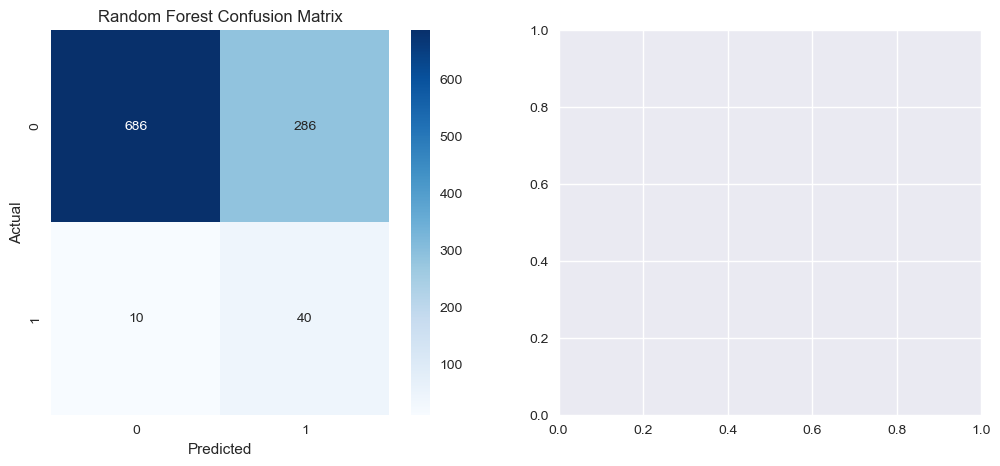

In [17]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred_thresh)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

Text(629.9949494949494, 0.5, 'Actual')

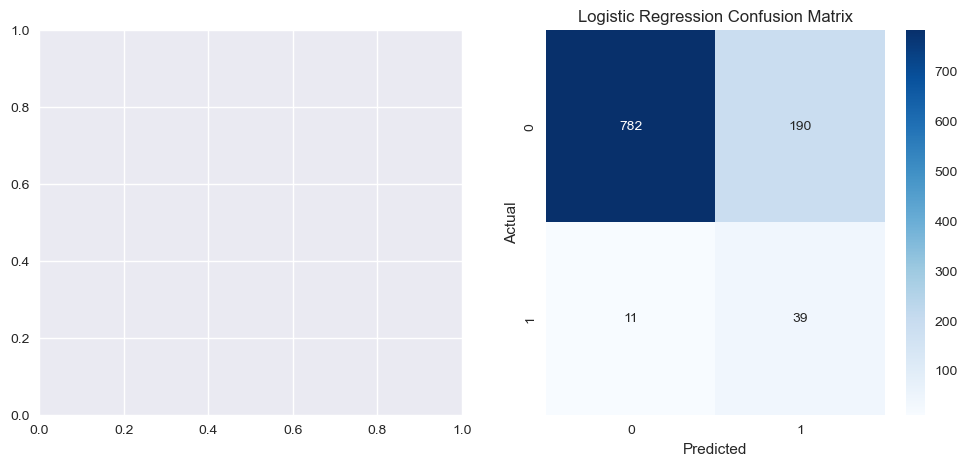

In [18]:
# Logistic Regression confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_lr = confusion_matrix(y_test, lr_pred_thresh)
sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')


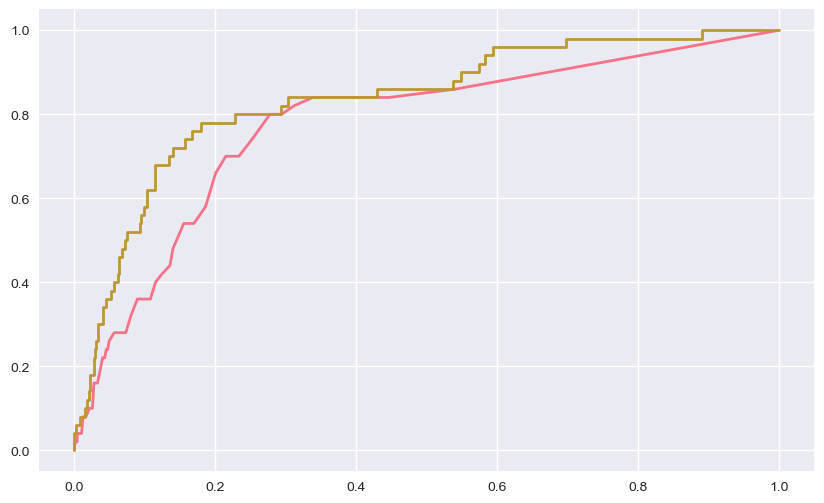

In [19]:
## 12. ROC Curves

plt.figure(figsize=(10, 6))

# Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_pred_proba):.3f})', linewidth=2)

# Logistic Regression ROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_proba)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_pred_proba):.3f})', linewidth=2)

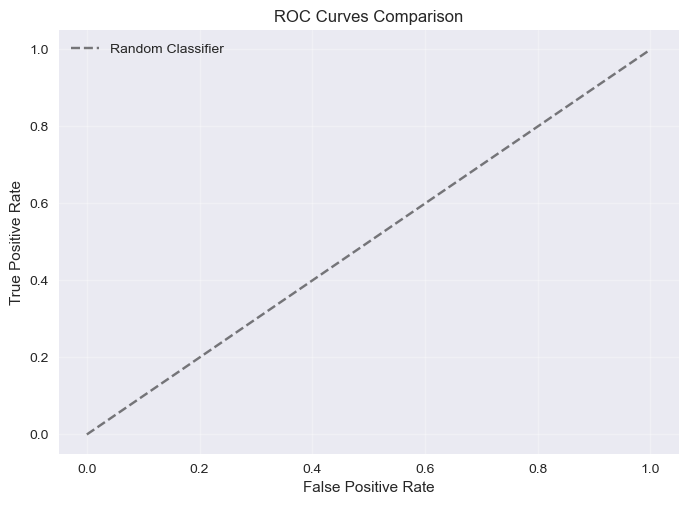

In [20]:
# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

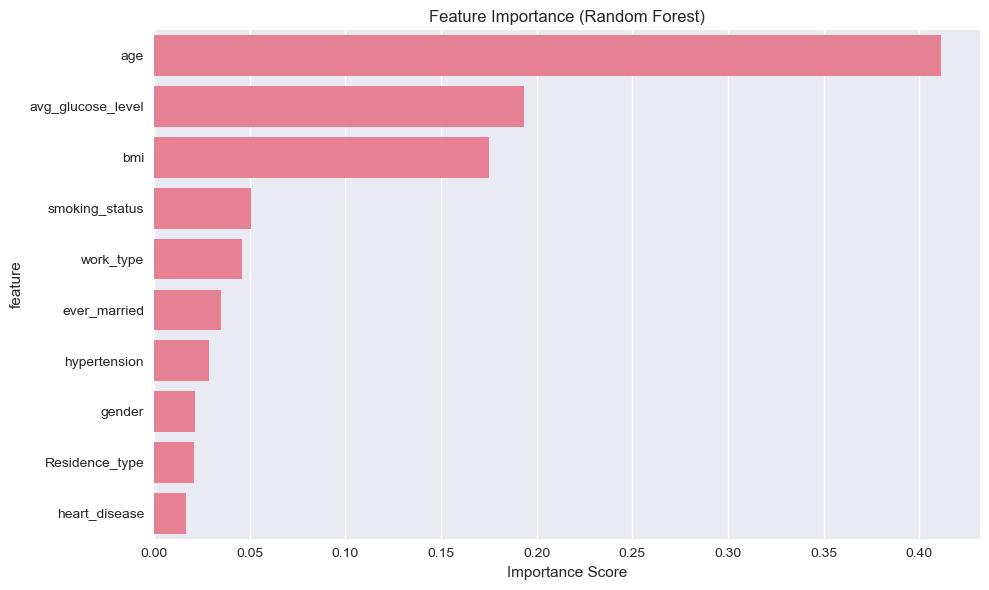

Top 5 Most Important Features:
             feature  importance
1                age    0.411117
7  avg_glucose_level    0.193594
8                bmi    0.175100
9     smoking_status    0.050714
5          work_type    0.046067


In [21]:
## 13. Feature Importance

# Random Forest feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance.head())


In [22]:
## 14. Summary and Insights



print(f"""
Dataset Overview:
- Total samples: {df.shape[0]:,}
- Features: {df.shape[1]-1}
- Stroke cases: {df['stroke'].sum():,} ({df['stroke'].mean()*100:.2f}%)

Key Findings:
1. Age is the strongest predictor of stroke risk
2. Average glucose level shows strong correlation with stroke
3. Hypertension and heart disease significantly increase stroke risk
4. The dataset is highly imbalanced (only {df['stroke'].mean()*100:.2f}% positive cases)

Model Performance:
- Random Forest AUC-ROC: {roc_auc_score(y_test, rf_pred_proba):.4f}
- Logistic Regression AUC-ROC: {roc_auc_score(y_test, lr_pred_proba):.4f}

""")


Dataset Overview:
- Total samples: 5,109
- Features: 12
- Stroke cases: 249 (4.87%)

Key Findings:
1. Age is the strongest predictor of stroke risk
2. Average glucose level shows strong correlation with stroke
3. Hypertension and heart disease significantly increase stroke risk
4. The dataset is highly imbalanced (only 4.87% positive cases)

Model Performance:
- Random Forest AUC-ROC: 0.7752
- Logistic Regression AUC-ROC: 0.8355




In [23]:
with open('stroke_prediction_model.pkl','wb') as file:
    pickle.dump(lr_model,file)